# 🔹UFC Fight Predictor Feature Engineering

<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 1. Import Libraries and Setup Environment

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get the current working directory
current_dir = os.getcwd()

# Navigate to the project root
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# Import from /src
sys.path.append(os.path.join(project_root, 'src'))
from utils.helpers import *
from utils.io_model import *
from utils.ufc_data import UFCData

<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 2. Load Data

In [2]:
# Define the path to the CSV file
file_path = os.path.join(project_root, 'data', 'processed', 'ufc_etl.csv')

# Load the CSV into a DataFrame
try:
    UFCDataDF = pd.read_csv(file_path)
except Exception as e:
    print_header(f"Error loading training data: {e}", color='bright_red')

<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 3. Feature Engineering

#### Create the target value: **0** (Fighter Red wins) or **1** (Fighter Blue wins)

In [3]:
UFCDataDF['label'] = UFCDataDF['Winner'].apply(lambda x: 1 if x == 'Blue' else 0)
UFCDataDF=UFCDataDF.drop('Winner', axis=1)

### Categorical Data

### Stance
- **Orthodox Stance:** A fighter in orthodox stance leads with their left foot and left hand, making it the natural stance for right-handed individuals. 
- **Southpaw Stance:** A fighter in southpaw stance leads with their right foot and right hand, making it the natural stance for left-handed individuals. 
- **Open Stance Matchup:** When one fighter is orthodox and the other is southpaw, it creates an "open stance" matchup. This differs from a "closed stance" where both fighters are in the same stance (e.g., both orthodox or both southpaw)
- **Switch:** When a fighter switches from an orthodox to a southpaw stance or vice versa, it can disrupt their opponent's rhythm, causing them to miss or react incorrectly to strikes. 

### Feature Construction

In [4]:
# Finish Rate (Red & Blue):
RedFinishRate = (UFCDataDF['RedWinsByKO'] + UFCDataDF['RedWinsBySubmission'] + UFCDataDF['RedWinsByTKODoctorStoppage']) / UFCDataDF['RedWins'].replace(0, 1)
BlueFinishRate = (UFCDataDF['BlueWinsByKO'] + UFCDataDF['BlueWinsBySubmission'] + UFCDataDF['BlueWinsByTKODoctorStoppage']) / UFCDataDF['BlueWins'].replace(0, 1)
UFCDataDF['FinishRate'] = BlueFinishRate - RedFinishRate

In [5]:
#Win Ratio (Red & Blue)
RedWinRatio = UFCDataDF['RedWins'] / (UFCDataDF['RedWins'] + UFCDataDF['RedLosses']).replace(0, 1)
BlueWinRatio = UFCDataDF['BlueWins'] / (UFCDataDF['BlueWins'] + UFCDataDF['BlueLosses']).replace(0, 1)
UFCDataDF['WinRatio']= BlueWinRatio - RedWinRatio 

In [6]:
# Experience per Age
RedExpPerAge = UFCDataDF['RedTotalRoundsFought'] / UFCDataDF['RedAge']
BlueExpPerAge = UFCDataDF['BlueTotalRoundsFought'] / UFCDataDF['BlueAge']
UFCDataDF['ExpPerAge'] = RedExpPerAge - BlueExpPerAge

In [7]:
# Reach Advantage Ratio
UFCDataDF['ReachAdvantageRatio'] = UFCDataDF['RedReachCms'] / UFCDataDF['BlueReachCms']

In [8]:
# Height/Reach Ratio
RedHeightReachRatio = UFCDataDF['RedHeightCms'] / UFCDataDF['RedReachCms']
BlueHeightReachRatio = UFCDataDF['BlueHeightCms'] / UFCDataDF['BlueReachCms']
UFCDataDF['HeightReachRatio']= BlueHeightReachRatio - RedHeightReachRatio

In [9]:
# Win By Decision
BlueWinsByDecision = UFCDataDF[['BlueWinsByDecisionMajority', 'BlueWinsByDecisionSplit', 'BlueWinsByDecisionUnanimous']].sum(axis=1)
RedWinsByDecision = UFCDataDF[['RedWinsByDecisionMajority', 'RedWinsByDecisionSplit', 'RedWinsByDecisionUnanimous']].sum(axis=1)
UFCDataDF['WinsByDecision']=BlueWinsByDecision- RedWinsByDecision

In [10]:
# Decision Rate
BlueDecisionRate = BlueWinsByDecision / UFCDataDF['BlueWins'].replace(0, 1)  # Evitar división por cero
RedDecisionRate = RedWinsByDecision  / UFCDataDF['RedWins'].replace(0, 1)  # Evitar división por cero
UFCDataDF['DecisionRate']= BlueDecisionRate - RedDecisionRate

### Feature Selection

Dado lo siguiente:
-  LoseStreakDif: BlueCurrentLoseStreak - RedCurrentLoseStreak
-  WinStreakDif: BlueCurrentWinStreak - RedCurrentWinStreak
-  LongestWinStreakDif: BlueLongestWinStreak - 'RedLongestWinStreak
-  WinDif: BlueWins - RedWins
-  LossDif: BlueLosses - RedLosses
-  TotalRoundDif: BlueTotalRoundsFought - RedTotalRoundsFought
-  TotalTitleBoutDif: BlueTotalTitleBouts - RedTotalTitleBouts
-  KODif: BlueWinsByKO - RedWinsByKO
-  SubDif: BlueWinsBySubmission - RedWinsBySubmission
-  HeightDif: BlueHeightCms - RedHeightCms
-  ReachDif: BlueReachCms - RedReachCms
-  AgeDif: BlueAge - RedAge
  
Se eliminan ciertas columnas que pueden ser redundantes.

In [11]:
UFCDataDF=UFCDataDF.drop(['BlueCurrentLoseStreak', 'RedCurrentLoseStreak','BlueCurrentWinStreak',
                      'RedCurrentWinStreak','BlueLongestWinStreak', 'RedLongestWinStreak', 'BlueWins',
                      'RedWins','BlueLosses','RedLosses', 'BlueTotalRoundsFought','RedTotalRoundsFought',
                      'BlueTotalTitleBouts', 'RedTotalTitleBouts', 'BlueWinsByKO', 'RedWinsByKO', 'BlueWinsBySubmission',
                      'RedWinsBySubmission','BlueHeightCms','RedHeightCms','BlueReachCms','RedReachCms',
                      'BlueAge', 'RedAge'], axis=1)

También aquellas relacionadas con los features construidos:
- WinsByDecision
- DecisionRate
- FinishRate


In [12]:
UFCDataDF=UFCDataDF.drop(['BlueWinsByDecisionSplit', 'BlueWinsByDecisionUnanimous',
       'BlueWinsByTKODoctorStoppage', 'RedWinsByDecisionMajority',
       'RedWinsByDecisionSplit', 'RedWinsByDecisionUnanimous',
       'RedWinsByTKODoctorStoppage','BlueWinsByDecisionMajority'], axis=1)

### Low Variance columns
- BlueDraws
- RedDraws
- BlueWeightLbs
- RedWeightLbs
- TitleBout_True 

In [13]:
UFCDataDF=UFCDataDF.drop(['BlueDraws','RedDraws','BlueWeightLbs','RedWeightLbs'], axis=1)

In [14]:
# Preview the first few records
display(UFCDataDF.head())
display(UFCDataDF.columns)
# Para ver los tipos de dato de cada columna:
display(UFCDataDF.dtypes)

TitleBout Gender  NumberOfRounds  BlueAvgSigStrLanded  BlueAvgSigStrPct  \
0      False   MALE               5                 4.13              0.36   
1      False   MALE               3                 7.36              0.56   
2      False   MALE               3                 3.32              0.48   
3      False   MALE               3                 5.50              0.47   
4      False   MALE               3                 5.94              0.52   

   BlueAvgSubAtt  BlueAvgTDLanded  BlueAvgTDPct BlueStance  \
0            0.0             1.96          0.46   Southpaw   
1            1.1             1.24          0.23   Orthodox   
2            0.2             2.26          0.28   Orthodox   
3            0.0             0.36          0.25   Orthodox   
4            0.0             0.25          0.50   Orthodox   

   RedAvgSigStrLanded  ...  BetterRank  TotalFightTimeSecs  label  FinishRate  \
0                3.88  ...         Red               882.0      1    0.283333   
1                4.67  ...     neither               696.0      0    0.293233   
2                4.44  ...         Red               717.0      0    0.500000   
3                2.82  ...     neither               824.0      1   -0.100000   
4                6.51  ...     neither               900.0      1   -0.607143   

   WinRatio  ExpPerAge  ReachAdvantageRatio  HeightReachRatio  WinsByDecision  \
0 -0.035714   0.477778             0.947368         -0.065058              -4   
1  0.042614   1.222222             1.000000          0.028571              -9   
2  0.095238   0.077799             1.046154          0.028733              -2   
3 -0.261905  -0.453704             1.013158          0.025803               2   
4  0.222222   0.064516             1.014493          0.013872               2   

   DecisionRate  
0     -0.283333  
1     -0.293233  
2     -0.500000  
3      0.100000  
4      0.607143  

[5 rows x 40 columns]

Index(['TitleBout', 'Gender', 'NumberOfRounds', 'BlueAvgSigStrLanded',
       'BlueAvgSigStrPct', 'BlueAvgSubAtt', 'BlueAvgTDLanded', 'BlueAvgTDPct',
       'BlueStance', 'RedAvgSigStrLanded', 'RedAvgSigStrPct', 'RedAvgSubAtt',
       'RedAvgTDLanded', 'RedAvgTDPct', 'RedStance', 'LoseStreakDif',
       'WinStreakDif', 'LongestWinStreakDif', 'WinDif', 'LossDif',
       'TotalRoundDif', 'TotalTitleBoutDif', 'KODif', 'SubDif', 'HeightDif',
       'ReachDif', 'AgeDif', 'SigStrDif', 'AvgSubAttDif', 'AvgTDDif',
       'BetterRank', 'TotalFightTimeSecs', 'label', 'FinishRate', 'WinRatio',
       'ExpPerAge', 'ReachAdvantageRatio', 'HeightReachRatio',
       'WinsByDecision', 'DecisionRate'],
      dtype='object')

TitleBout                 bool
Gender                  object
NumberOfRounds           int64
BlueAvgSigStrLanded    float64
BlueAvgSigStrPct       float64
BlueAvgSubAtt          float64
BlueAvgTDLanded        float64
BlueAvgTDPct           float64
BlueStance              object
RedAvgSigStrLanded     float64
RedAvgSigStrPct        float64
RedAvgSubAtt           float64
RedAvgTDLanded         float64
RedAvgTDPct            float64
RedStance               object
LoseStreakDif            int64
WinStreakDif             int64
LongestWinStreakDif      int64
WinDif                   int64
LossDif                  int64
TotalRoundDif            int64
TotalTitleBoutDif        int64
KODif                    int64
SubDif                   int64
HeightDif              float64
ReachDif               float64
AgeDif                   int64
SigStrDif              float64
AvgSubAttDif           float64
AvgTDDif               float64
BetterRank              object
TotalFightTimeSecs     float64
label   

In [15]:
display(UFCDataDF.head())

TitleBout Gender  NumberOfRounds  BlueAvgSigStrLanded  BlueAvgSigStrPct  \
0      False   MALE               5                 4.13              0.36   
1      False   MALE               3                 7.36              0.56   
2      False   MALE               3                 3.32              0.48   
3      False   MALE               3                 5.50              0.47   
4      False   MALE               3                 5.94              0.52   

   BlueAvgSubAtt  BlueAvgTDLanded  BlueAvgTDPct BlueStance  \
0            0.0             1.96          0.46   Southpaw   
1            1.1             1.24          0.23   Orthodox   
2            0.2             2.26          0.28   Orthodox   
3            0.0             0.36          0.25   Orthodox   
4            0.0             0.25          0.50   Orthodox   

   RedAvgSigStrLanded  ...  BetterRank  TotalFightTimeSecs  label  FinishRate  \
0                3.88  ...         Red               882.0      1    0.283333   
1                4.67  ...     neither               696.0      0    0.293233   
2                4.44  ...         Red               717.0      0    0.500000   
3                2.82  ...     neither               824.0      1   -0.100000   
4                6.51  ...     neither               900.0      1   -0.607143   

   WinRatio  ExpPerAge  ReachAdvantageRatio  HeightReachRatio  WinsByDecision  \
0 -0.035714   0.477778             0.947368         -0.065058              -4   
1  0.042614   1.222222             1.000000          0.028571              -9   
2  0.095238   0.077799             1.046154          0.028733              -2   
3 -0.261905  -0.453704             1.013158          0.025803               2   
4  0.222222   0.064516             1.014493          0.013872               2   

   DecisionRate  
0     -0.283333  
1     -0.293233  
2     -0.500000  
3      0.100000  
4      0.607143  

[5 rows x 40 columns]

## 4. Initialize UFCData object

In [16]:
UFCData = UFCData(UFCDataDF)

In [17]:
UFCData.summary()

🧪Samples: 6541
🧪Train/Test split: 5232/1309
🧪Features: 39
🧪Categorical: 5, Numerical: 34


<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 5. Inicialize Modeling Data: Standarize Numerical Data & Encode Categorical Data

In [18]:
UFCData.standardize()
UFCData.encode()
UFCData.compute_corr()

## 6. Check Modeling Data

In [19]:
UFCData._X_train_processed

TitleBout  Gender_MALE  BlueStance_Orthodox  BlueStance_Southpaw  \
5014          0            1                    0                    1   
3094          0            1                    0                    1   
3760          0            1                    0                    1   
3951          0            1                    1                    0   
6431          0            1                    1                    0   
...         ...          ...                  ...                  ...   
3513          0            1                    1                    0   
2366          0            1                    1                    0   
2982          0            1                    0                    1   
4536          0            0                    1                    0   
1441          0            1                    0                    1   

      BlueStance_Switch  RedStance_Open Stance  RedStance_Orthodox  \
5014                  0                      0                   0   
3094                  0                      0                   1   
3760                  0                      0                   1   
3951                  0                      0                   1   
6431                  0                      0                   0   
...                 ...                    ...                 ...   
3513                  0                      0                   1   
2366                  0                      0                   1   
2982                  0                      0                   1   
4536                  0                      0                   1   
1441                  0                      0                   1   

      RedStance_Southpaw  RedStance_Switch  BetterRank_Blue  ...  \
5014                   1                 0                0  ...   
3094                   0                 0                0  ...   
3760                   0                 0                0  ...   
3951                   0                 0                0  ...   
6431                   1                 0                0  ...   
...                  ...               ...              ...  ...   
3513                   0                 0                0  ...   
2366                   0                 0                0  ...   
2982                   0                 0                0  ...   
4536                   0                 0                0  ...   
1441                   0                 0                0  ...   

      AvgSubAttDif  AvgTDDif  TotalFightTimeSecs  FinishRate  WinRatio  \
5014     -1.025880  0.102213            0.708351    0.161448  0.275168   
3094      0.079948  0.102213           -1.000753    0.161448  0.275168   
3760     -0.104394 -0.184490            2.458287   -0.755016 -0.415658   
3951      0.448520  0.102213            0.708351   -0.525900  0.275168   
6431     -1.394452  0.675620           -0.924923   -0.525900  0.275168   
...            ...       ...                 ...         ...       ...   
3513     -0.235987  0.347976            2.458287    0.092713  0.373858   
2366     -1.799959 -0.677620            0.708351   -0.400928  0.543125   
2982      0.102064 -0.207426           -1.432404   -1.728758  1.712087   
4536     -1.578793 -3.338228            0.708351    0.161448 -1.106484   
1441      1.738689  1.822434            0.708351   -0.457165  1.337978   

      ExpPerAge  ReachAdvantageRatio  HeightReachRatio  WinsByDecision  \
5014  -0.164815            -0.035200          0.369952        0.268586   
3094  -0.323718            -0.035200          1.528038        0.268586   
3760   0.941574             1.652897          2.497677       -0.940745   
3951  -1.034251            -1.538300         -1.625058        0.671696   
6431  -0.006187            -0.949586         -0.810404       -0.134524   
...         ...                  ...               ...             ...   
3513   0.502277            -0.316550         -0.7457

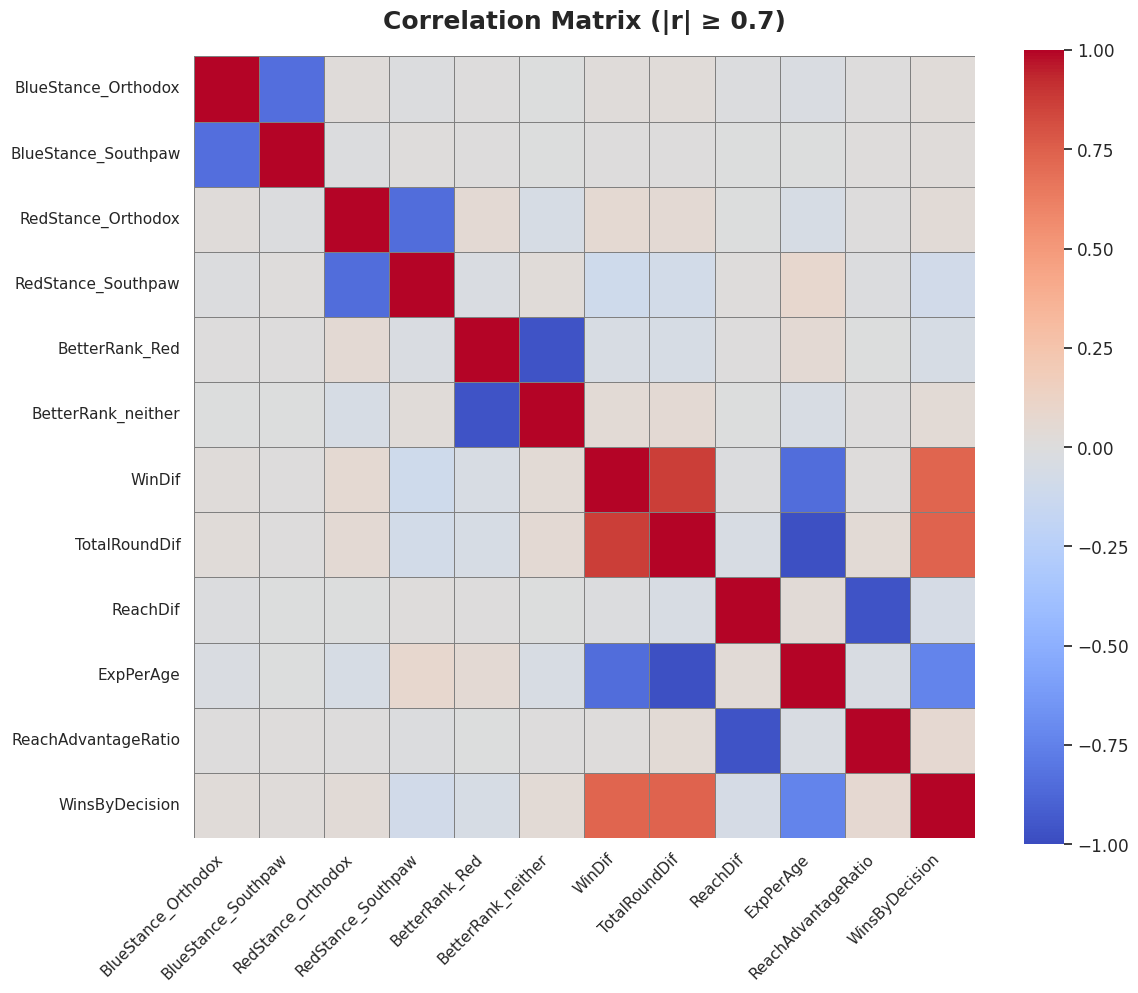

In [20]:
UFCData.plot_corr(threshold = 0.7)

In [21]:
UFCData.top_corr()

Feature 1            Feature 2  Correlation
894         TotalRoundDif            ExpPerAge     0.980629
405        BetterRank_Red   BetterRank_neither     0.967431
965              ReachDif  ReachAdvantageRatio     0.965241
846                WinDif        TotalRoundDif     0.868544
859                WinDif            ExpPerAge     0.849347
255    RedStance_Orthodox   RedStance_Southpaw     0.846054
89    BlueStance_Orthodox  BlueStance_Southpaw     0.840822
897         TotalRoundDif       WinsByDecision     0.741877
1027            ExpPerAge       WinsByDecision     0.737463
862                WinDif       WinsByDecision     0.732486
725          RedAvgSubAtt         AvgSubAttDif     0.694582
825   LongestWinStreakDif               WinDif     0.660869
750        RedAvgTDLanded             AvgTDDif     0.655455
620       BlueAvgTDLanded             AvgTDDif     0.652204
1029  ReachAdvantageRatio     HeightReachRatio     0.647478
590         BlueAvgSubAtt         AvgSubAttDif     0.640151
848                WinDif                KODif     0.636898
966              ReachDif     HeightReachRatio     0.623837
11              TitleBout       NumberOfRounds     0.617500
953             HeightDif  ReachAdvantageRatio     0.616084
944             HeightDif             ReachDif     0.598250
511   BlueAvgSigStrLanded   RedAvgSigStrLanded     0.597130
1019           FinishRate         DecisionRate     0.549095
600       BlueAvgTDLanded         BlueAvgTDPct     0.548994
1034       WinsByDecision         DecisionRate     0.520126
735        RedAvgTDLanded          RedAvgTDPct     0.513918
883         TotalRoundDif                KODif     0.509864
843   LongestWinStreakDif       WinsByDecision     0.507901
840   LongestWinStreakDif            ExpPerAge     0.507438

<div style="text-align: center;">
  🔹 <img src="../img/ufc_logo.png" width="50" /> 🔹
</div>

## 5. Save

In [30]:
save_data(UFCData)

✅ UFCData object saved to: /home/mfourier/ufc-predictor/data/processed/ufc_data.pkl


In [31]:
save_ufc_datasets(UFCData, project_root)

✅ UFCData object saved to: dict_keys(['ufc_train.csv', 'ufc_test.csv', 'ufc_processed_train.csv', 'ufc_processed_test.csv'])


<div style="text-align: center;">
     <img src="../img/ufc_logo.png" width="800" /> 
</div>